# Transformer Experiments

## Packages and Presets

In [1]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import yaml
from icecream import ic


import matplotlib.pyplot as plt
import seaborn as sns   

from sklearn.metrics import (
    f1_score, 
    balanced_accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report
)
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split



from transformer_utils import PTB_Dataset, test

from transformer import Transformer

pd.set_option('display.max_columns', None)
%load_ext blackcellmagic
%load_ext autoreload

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with open("transformer_config.yaml", "r") as file:
    config = yaml.safe_load(file)

## Performance Evaluation

In [3]:
# Load data
train_df = pd.read_csv(config["paths"]["ptb_train"], header=None)
test_df = pd.read_csv(config["paths"]["ptb_test"], header=None)

In [4]:
X_train_full = train_df.iloc[:, :-1].to_numpy()
y_train_full = train_df.iloc[:, -1].to_numpy()

X_test = test_df.iloc[:, :-1].to_numpy()
y_test = test_df.iloc[:, -1].to_numpy()

X_train_full = np.c_[X_train_full, np.zeros((X_train_full.shape[0], 3))]
X_test = np.c_[X_test, np.zeros((X_test.shape[0], 3))]

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

Contrary to the `train_transformer.py` script, we will here not make use of SMOTE oversampling as this notebook is only about evaluating the model performance on the test set and visualizing the attention map of some representative images.

In [6]:
train_loader = DataLoader(
    PTB_Dataset(X_train, y_train), batch_size=config["dataloader"]["train_batch_size"], shuffle=True, pin_memory=True
)
val_loader = DataLoader(
    PTB_Dataset(X_val, y_val), batch_size=config["dataloader"]["val_batch_size"], shuffle=False, pin_memory=True
)

test_loader = DataLoader(
    PTB_Dataset(X_test, y_test), batch_size=config["dataloader"]["test_batch_size"], shuffle=False, pin_memory=True
)


## Evaluating Model Performance

In [7]:
criterion = nn.CrossEntropyLoss()
model = Transformer(
    num_classes=config["transformer"]["num_classes"],
    input_size=config["transformer"]["input_size"],
    model_size=config["transformer"]["model_size"],
    num_heads=config["transformer"]["num_heads"],
    num_layers=config["transformer"]["num_encoder_layers"],
    d_ff=config["transformer"]["dim_feed_forward"],
    dropout=config["transformer"]["dropout"],
    transformer_activation=config["transformer"]["transformer_activation"],
    use_padding_mask=config["transformer"]["use_padding_mask"],
)
model.load_state_dict(
    torch.load(config["paths"]["transformer_model"], map_location=DEVICE)
)
model = model.to(DEVICE)

In [8]:
model_probs, y_preds, y_true, test_loss = test(
    model = model,
    criterion = criterion, 
    test_loader = test_loader, 
    device = DEVICE
)

Test loss: 0.0002, Test accuracy: 0.9924, Test balanced accuracy: 0.9894, Test F1 score: 0.9948


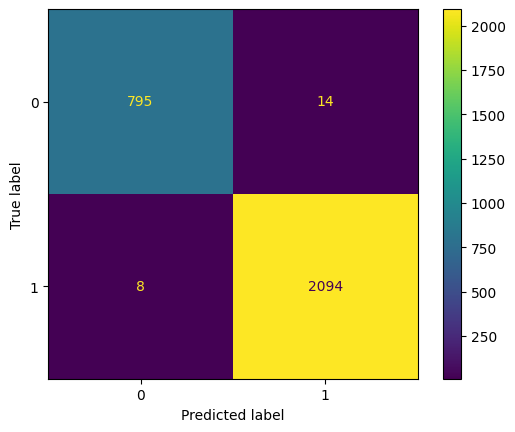

In [9]:
cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

In [10]:
# calculate precision and recall:
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"Test loss: {test_loss:.6f}")
print(f"Test accuracy: {accuracy_score(y_true, y_preds):.6f}")
print(f"Test balanced accuracy: {balanced_accuracy_score(y_true, y_preds):.6f}")
print(f"Test f1 score: {f1_score(y_true, y_preds):.6f}")
print(f"Test precision: {precision:.6f}")
print(f"Test recall: {recall:.6f}")

Test loss: 0.000170
Test accuracy: 0.992442
Test balanced accuracy: 0.989444
Test f1 score: 0.994774
Test precision: 0.993359
Test recall: 0.996194


In [11]:
print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       809
           1       0.99      1.00      0.99      2102

    accuracy                           0.99      2911
   macro avg       0.99      0.99      0.99      2911
weighted avg       0.99      0.99      0.99      2911



## Visualizing Attention Map

In [12]:
#!!! This class was copied from here:
#!!! https://gist.github.com/airalcorn2/50ec06517ce96ecc143503e21fa6cb91
class SaveOutput:
    def __init__(self):
        self.outputs = []

    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out[1])

    def clear(self):
        self.outputs = []

In [13]:
X_train_neg = X_train[y_train == 0]
X_train_pos = X_train[y_train == 1]

y_train_neg = y_train[y_train == 0]
y_train_pos = y_train[y_train == 1]

neg_dataset = PTB_Dataset(X_train_neg, y_train_neg)
pos_dataset = PTB_Dataset(X_train_pos, y_train_pos)

In [14]:
x, label = neg_dataset[1]
print(x.shape)
_, weights = model(x.to(DEVICE).unsqueeze(0), get_weights=True)

torch.Size([190, 1])


In [15]:
weights[0].shape

torch.Size([1, 190, 190])

In [16]:
X_train_neg[0]

array([0.92382377, 0.7669903 , 0.29424945, 0.        , 0.13442868,
       0.2755788 , 0.41299477, 0.32113516, 0.30321136, 0.32860345,
       0.30918595, 0.32636297, 0.33009708, 0.33009708, 0.35026139,
       0.36743838, 0.3965646 , 0.39058998, 0.41000748, 0.44585511,
       0.45407021, 0.48842421, 0.523525  , 0.53846157, 0.60940999,
       0.592233  , 0.63405526, 0.62882751, 0.63554889, 0.65646005,
       0.66616881, 0.67737114, 0.6348021 , 0.59148616, 0.5660941 ,
       0.51530993, 0.49663928, 0.43988052, 0.41448843, 0.42793128,
       0.38909635, 0.41224796, 0.38984317, 0.38760269, 0.42120987,
       0.39581779, 0.42120987, 0.41150111, 0.39880508, 0.40403286,
       0.40179238, 0.40702015, 0.39058998, 0.39357731, 0.45780432,
       0.48543689, 0.52203137, 0.55489171, 0.55414486, 0.57505602,
       0.58103061, 0.57281554, 0.62509334, 0.5496639 , 0.50933534,
       0.45780432, 0.41822255, 0.38237491, 0.34727409, 0.35772964,
       0.3278566 , 0.33233756, 0.32561612, 0.34129947, 0.39432

torch.Size([5, 190, 190])
torch.Size([190, 190])


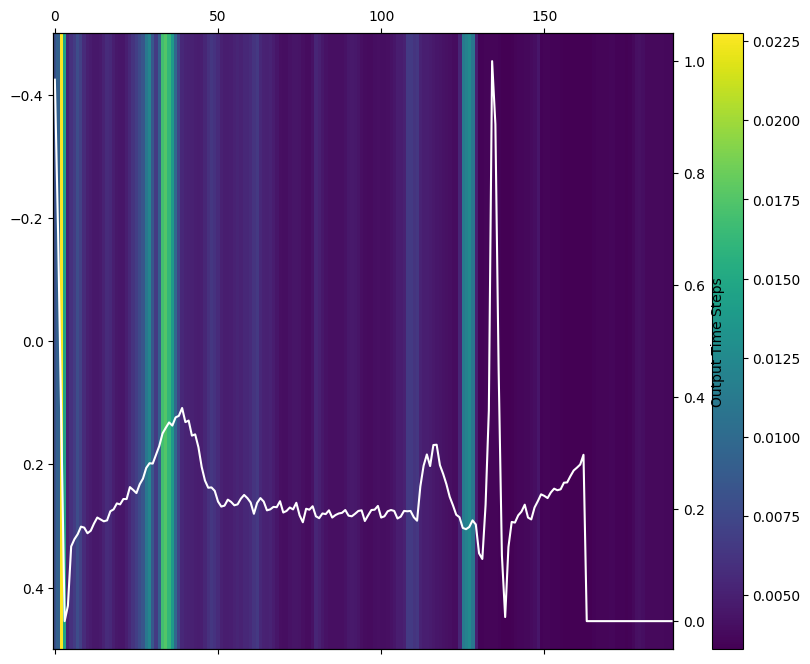

In [17]:
def plot_one_attention_map(model: nn.Module, dataset: Dataset, idx: int):
    x, label = neg_dataset[idx]
    model.eval()
    logit, weights = model(x.to(DEVICE).unsqueeze(0), get_weights=True)
    pred = torch.argmax(logit, dim=1).item()
    true = label.item()
    
    # stack the weights of all attention layers
    stacked_weights = torch.stack(weights).squeeze(1) # shape: (num_layers, query_len, key_len)]
    print(stacked_weights.shape)
    # aggregate over layers
    agg_weights = stacked_weights.mean(dim=0) # shape: (, query_len, key_len)
    # aggregate over output sequence
    mean_weights = agg_weights.mean(axis=0).squeeze(0).cpu().detach().numpy() # shape: (key_len,)
    print(agg_weights.shape)
    
    fig, ax1 = plt.subplots(figsize=(10, 8))
    cax = ax1.matshow(mean_weights[None, :], aspect='auto', cmap='viridis')
    fig.colorbar(cax)
    # plot time series in black above
    ax2 = ax1.twinx()
    ax2.plot(range(len(X_train_pos[0])), X_train_pos[0], color='white')
    ax2.set_xlabel("Input Time Steps")
    ax2.set_ylabel("Output Time Steps")
    plt.show()
    
plot_one_attention_map(model, neg_dataset, 5)

torch.Size([190, 190])


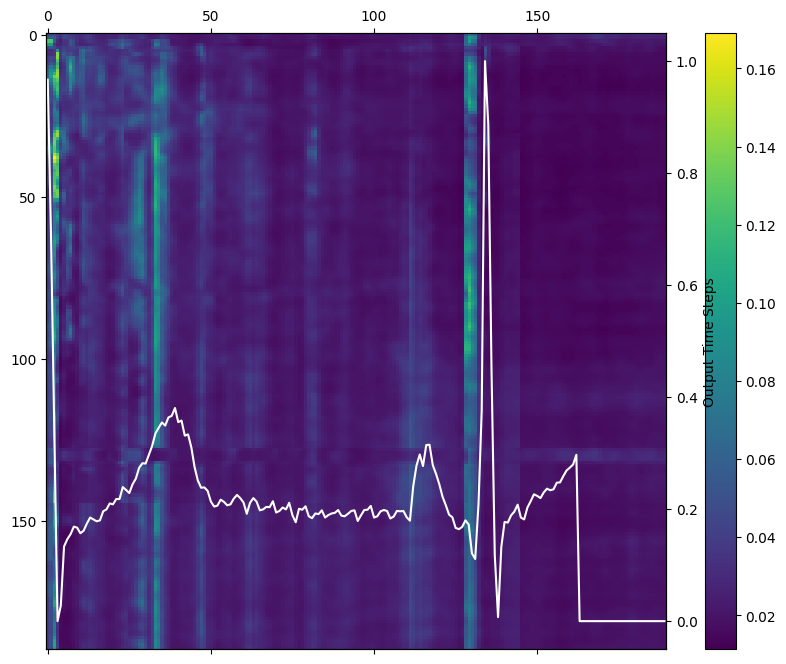

In [18]:
agg_weights = torch.stack(weights, dim=0).sum(dim=0).squeeze(0)
print(agg_weights.shape)
fig, ax1 = plt.subplots(figsize=(10, 8))
cax = ax1.matshow(agg_weights.squeeze(0).detach().cpu().numpy(), aspect='auto', cmap='viridis')
fig.colorbar(cax)
# plot time series in black above
ax2 = ax1.twinx()
ax2.plot(range(len(X_train_pos[0])), X_train_pos[0], color='white')
ax2.set_xlabel("Input Time Steps")
ax2.set_ylabel("Output Time Steps")
plt.show()

In [19]:
#!!! This function was copied from here:
#!!! https://gist.github.com/airalcorn2/50ec06517ce96ecc143503e21fa6cb91
def patch_attention(model:nn.Module) -> None:
    """Patch the attention mechanism of the model to return the attention weights

    Args:
        model (nn.Module): Model
    """
    forward_orig = model.forward

    def wrap(*args, **kwargs):
        kwargs['need_weights'] = True
        kwargs['average_attn_weights'] = False

        return forward_orig(*args, **kwargs)

    model.forward = wrap

In [20]:
pos_dataset[:2][0].shape

torch.Size([2, 190, 1])

In [21]:
def get_attention_for_seq(model:nn.Module, seq:np.ndarray) -> list[torch.Tensor]:
    """_summary_

    Args:
        model (nn.Module): Model for which to get the attention
        seq (np.ndarray): Sequence for which to get the attention. Should have
            shape [batch_size, seq_len, input_size]

    Returns:
        list[torch.Tensor]: List of attention weights for each encoder layer.
    """
    save_output = SaveOutput()
    model.eval()
    
    #!!! This for loop was copied from here:
    #!!! https://gist.github.com/airalcorn2/50ec06517ce96ecc143503e21fa6cb91
    for module in model.transformer_encoder.modules():
        if isinstance(module, nn.MultiheadAttention):
            patch_attention(module)
            module.register_forward_hook(save_output)

    with torch.no_grad():
        _ = model.transformer_encoder(model.embedding(torch.tensor(seq, dtype=torch.float32).to(DEVICE).permute(1, 0, 2)))
    return save_output.outputs

att_lst = get_attention_for_seq(model, X_train_neg[:1][:, :, None])
print(len(att_lst))
print(att_lst[0].shape) # 1st encoder layer
print(att_lst[1].shape) # 2nd encoder layer
print(att_lst[2].shape) # 3rd encoder layer

AttributeError: 'tuple' object has no attribute 'dtype'

Note that the attention weights for each layer have shape `[batch_size, num_heads, query_length, key_length]`, where `num_heads` is the number of attention heads, `query_length` and `key_length` are the length of the  sequence under consideration.

In [ ]:
#!!! This function is based on the code from the following source:
#!!! https://github.com/jeonsworld/ViT-pytorch/blob/main/visualize_attention_map.ipynb
def aggregate_attention(att_lst: list[torch.Tensor]) -> torch.Tensor:
    """Aggregate the attention weights of all encoder layers

    Args:
        att_lst (list[torch.Tensor]): List of attention weights for each encoder layer

    Returns:
        torch.Tensor: Aggregated attention weights
    """
    # stack the attention weights of all layers on top of each other
    # and remove unnecessary dimension
    att = torch.stack(att_lst).squeeze(1).detach()
    # calculate mean over all heads
    att = torch.mean(att, dim=1)
    
    residual_att = torch.eye(att.size(1)).to(DEVICE).unsqueeze(0)
    ic(att.shape)
    aug_att_mat = att + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
    
    
    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros_like(aug_att_mat).to(DEVICE)
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n - 1])
    
    return joint_attentions

joint_attentions = aggregate_attention(att_lst)
joint_attentions.shape

ic| att.shape: torch.Size([5, 190, 190])


torch.Size([5, 190, 190])

In [ ]:
att = torch.stack(att_lst).squeeze(1).detach().cpu()
att_mat = torch.stack(att_lst).squeeze(1).detach().cpu() 
assert torch.all(att == att_mat)
# calculate mean over all heads
att = torch.mean(att, dim=1)
# Average the attention weights across all heads
att_mat = torch.mean(att_mat, dim=1) 
assert torch.all(att == att_mat)

residual_att = torch.eye(att.size(1)).unsqueeze(0)
ic(att.shape)
aug_att_mat = att + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

identity = torch.eye(att_mat.size(1))
aug_att_mat2 = att_mat + identity.unsqueeze(0)  # Unsqueeze to add layer dimension back for broadcasting
aug_att_mat2 = aug_att_mat2 / aug_att_mat2.sum(dim=-1, keepdim=True)

assert torch.all(aug_att_mat == aug_att_mat2)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros_like(aug_att_mat)
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
    
joint_attentions2 = torch.zeros_like(aug_att_mat2)
joint_attentions2[0] = aug_att_mat2[0]

for n in range(1, aug_att_mat2.size(0)):
    joint_attentions2[n] = torch.matmul(aug_att_mat2[n], joint_attentions2[n-1])
assert torch.all(joint_attentions==joint_attentions2)

ic| att.shape: torch.Size([5, 190, 190])


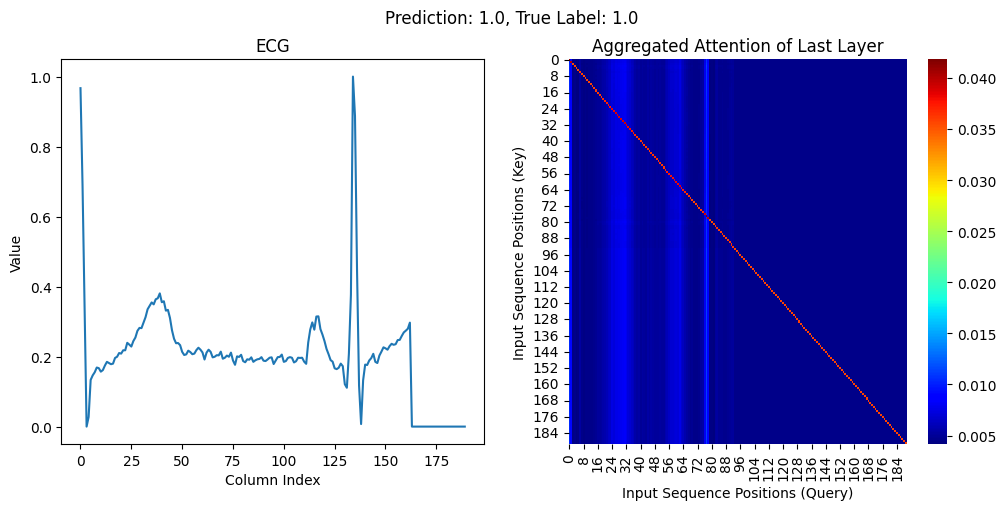

In [ ]:
def plot_attention_last_layer(
    model: nn.Module, seq: np.ndarray, label: np.ndarray, joint_attentions: torch.Tensor
) -> None:
    """Plot the attention weights

    Args:
        model (nn.Module): Model from which attention weights have been extracted
        seq (np.ndarray): Sequence
        label: Label of the sequence
        joint_attentions (torch.Tensor): Aggregated attention weights
    """
    # calculate model prediction:
    model.eval()
    pred_label = (
        F.softmax(
            model(
                torch.tensor(seq, dtype=torch.float32).to(DEVICE).unsqueeze(0).unsqueeze(2)
            ),
            dim=1,
        )
        .argmax(dim=1)
        .cpu()
        .numpy()
        .astype(float)
        .item()
    )
    # last attention from output layer to input space
    v = joint_attentions[-1]
    # plot ecg on left, corrresponding attention map on the right
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"Prediction: {pred_label}, True Label: {label}")
    ax = ax.flatten()
    ax[0].plot(np.arange(0, seq.size), seq, marker=None, linestyle="-")
    ax[0].set_title("ECG")
    ax[0].set_xlabel("Column Index")
    ax[0].set_ylabel("Value")
    sns.heatmap(v.cpu().numpy(), ax=ax[1], annot=False, cmap="jet", cbar=True)
    ax[1].set_title("Aggregated Attention of Last Layer")
    ax[1].set_xlabel("Input Sequence Positions (Query)")
    ax[1].set_ylabel("Input Sequence Positions (Key)")
    plt.show()


plot_attention_last_layer(model, X_train_pos[0], y_train_pos[0], joint_attentions)

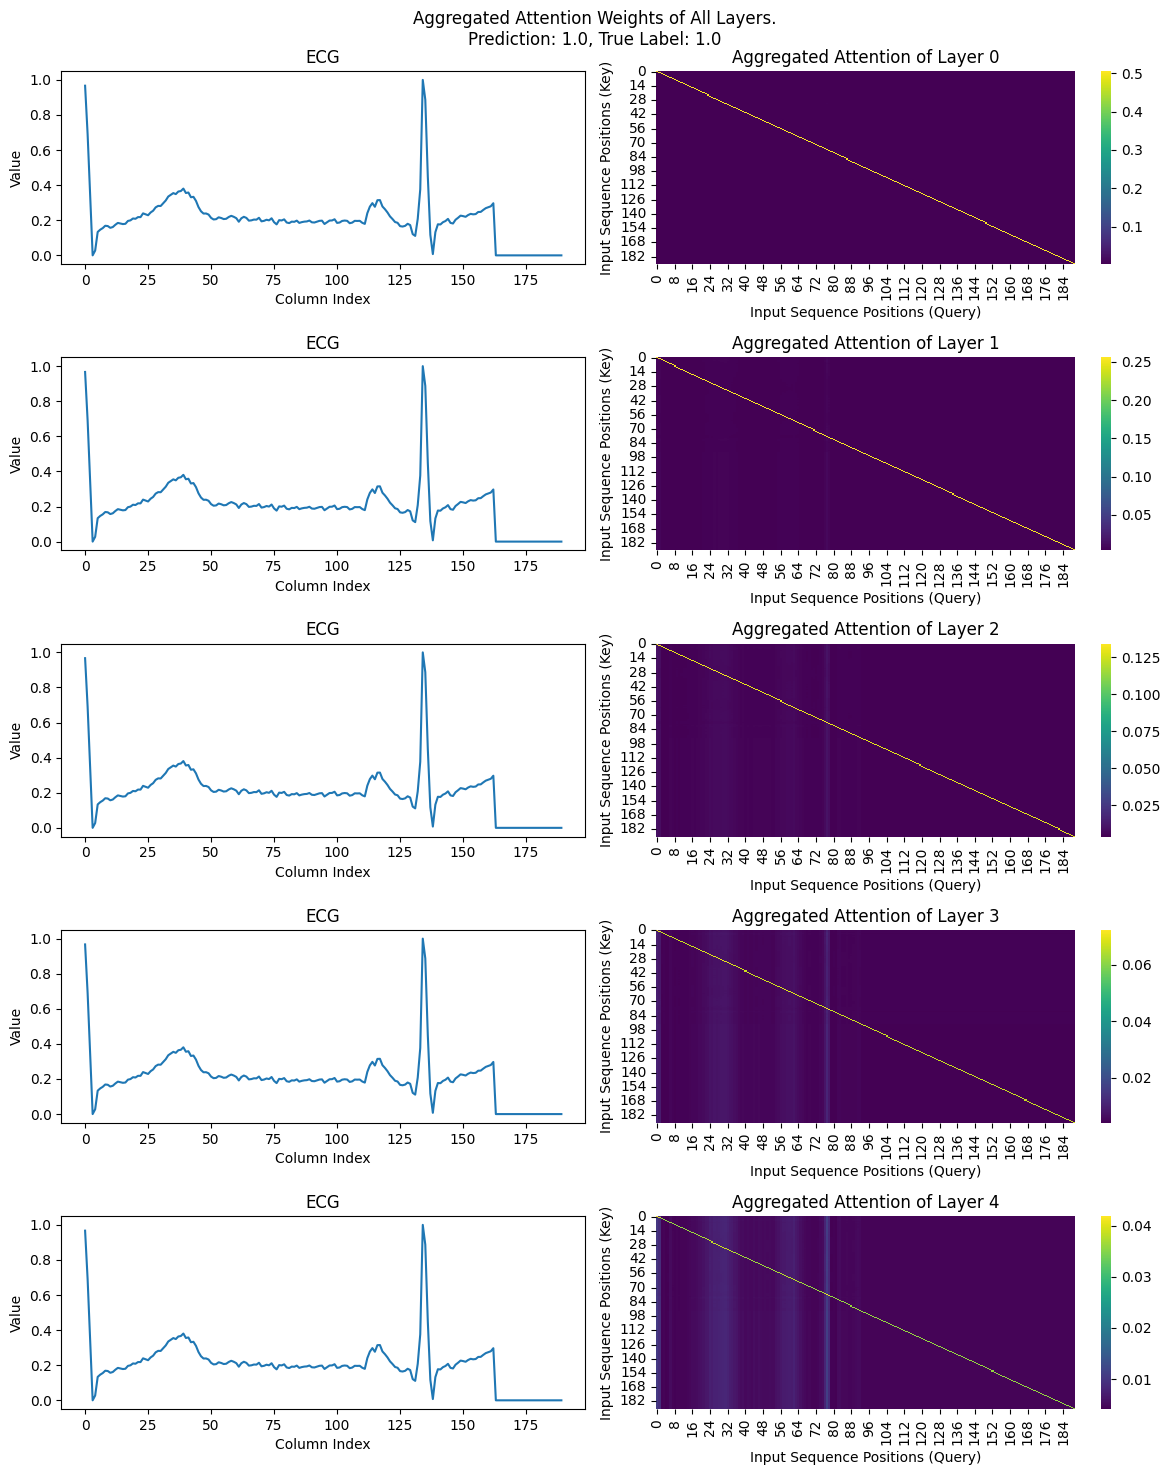

In [ ]:
def plot_attention_all_layers(
    model: nn.Module, seq: np.ndarray, label: np.ndarray, joint_attentions: torch.Tensor
) -> None:
    """Plot the attention weights

    Args:
        model (nn.Module): Model from which attention weights have been extracted
        seq (np.ndarray): Sequence
        label: Label of the sequence
        joint_attentions (torch.Tensor): Aggregated attention weights
    """
    # calculate model prediction:
    fig, ax = plt.subplots(joint_attentions.shape[0], 2, figsize=(12, 15))
    model.eval()
    pred_label = (
        F.softmax(
            model(
                torch.tensor(seq, dtype=torch.float32).to(DEVICE).unsqueeze(0).unsqueeze(2)
            ),
            dim=1,
        )
        .argmax(dim=1)
        .cpu()
        .numpy()
        .astype(float)
        .item()
    )
    fig.suptitle(f"Aggregated Attention Weights of All Layers.\nPrediction: {pred_label}, True Label: {label}")
    for i, v in enumerate(joint_attentions):
        ax[i, 0].plot(np.arange(0, seq.size), seq, marker=None, linestyle="-")
        ax[i, 0].set_title(f"ECG")
        ax[i, 0].set_xlabel("Column Index")
        ax[i, 0].set_ylabel("Value")
        
        sns.heatmap(v.cpu().numpy(), ax=ax[i, 1], annot=False, cmap="viridis")
        ax[i, 1].set_title(f"Aggregated Attention of Layer {i}")
        ax[i, 1].set_xlabel("Input Sequence Positions (Query)")
        ax[i, 1].set_ylabel("Input Sequence Positions (Key)")
    plt.tight_layout()
    plt.show()

plot_attention_all_layers(model, X_train_pos[0], y_train_pos[0], joint_attentions)

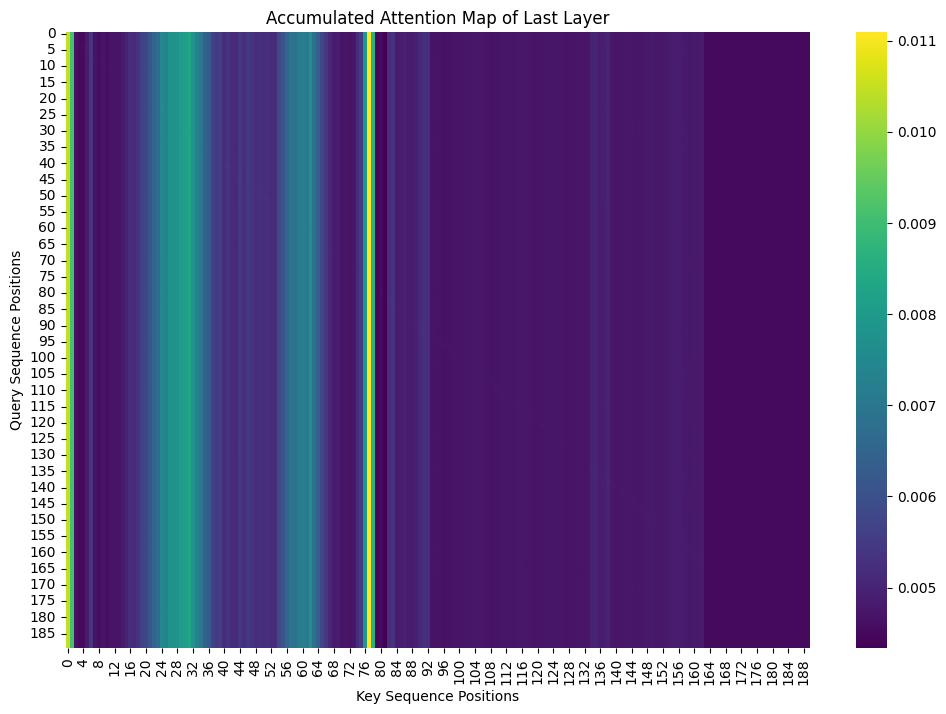

In [ ]:
att_mat = torch.stack(att_lst).squeeze(1).detach().cpu()  # Remove batch dimension, shape [num_layers, num_heads, query_length, key_length]

# Average the attention weights across all heads
att_mat = torch.mean(att_mat, dim=1)  # Shape [num_layers, query_length, key_length]

# To account for residual connections, we add an identity matrix to the attention matrix and re-normalize the weights
identity = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + identity.unsqueeze(0)  # Unsqueeze to add layer dimension back for broadcasting
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1, keepdim=True)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros_like(aug_att_mat)
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

# Now, each matrix in 'joint_attentions' shows the accumulated attention up to that layer.
# To visualize, select the attention matrix from the last layer
last_layer_attention = joint_attentions[-1]

# Plotting
# If you want to visualize how a specific token attends to the rest of the sequence
# you might select a particular query position, for example, the final output token:
plt.figure(figsize=(12, 8))
sns.heatmap(last_layer_attention.cpu().numpy(), cmap='viridis', cbar=True)
plt.title('Accumulated Attention Map of Last Layer')
plt.xlabel('Key Sequence Positions')
plt.ylabel('Query Sequence Positions')
plt.show()

In [ ]:
# negative:
